## **Exercício 4 - de Uso de LSTM**

### **REDES NEURAIS RECORRENTES**

### Profa. Roseli Ap. Francelin Romero

### Grupo:
- Julyana Flores de Prá (colocarNUSP)
- Thiago Rafael Mariotti Claudio (15611674)

**PROBLEMA**: OBTENHA UMA SERIE TEMPORAL

Escolha uma série temporal do seu interesse, como por exemplo, uma série sobre a variação de preços de produtos ao consumidor, ou uma série sobre a variação do dolar nos ultimos anos. Monte uma base de dados de aproximadamente 1000 registros em formato cvs.

Siga os seguintes passos para realizar este projeto e use o exemplo disponibilizado no Drive da disciplina no diretório Aula3. </br>

*  Carregar o dataset do CSV file.

Transformar o dataset de modo a adequa-lo para o modelo LSTM, incluindo:
* 1 - Transformar os dados para um problema de aprendizado supervisionado.
* 2 - Transformar os dados para ser "estacionario", considerando passo =1, ou seja, timestep =1.
* 3 - Transformar os dados para que fiquem no interv. [-1,1].
* 4 - Ajusta o modelo da rede LSTM para o conj. de treinamento.
Implementar considerando: 5 LSTMs e depois 10 LSTMs
* 5 - Avaliar os dois modelos de LSTM estático no conjunto de teste.
* 6 - Visualizar o desempenho da Previsão.

---
Para essa atividade, o conjunto [House Property Sales Time Series](https://www.kaggle.com/datasets/htagholdings/property-sales?select=ma_lga_12345.csv) selecionado apresenta evolução do preço de imóveis ao longo do período compreendido entre 31/03/2007 até 30/09/2019, observando apenas o tipo do imóvel e a quantidade de cômodos, permitindo trabalhar com mapeamento e dimensionamento de atributos, pré-processamento e aplicar técnicas de séries temporais.

A escolha temática da base foi dada à esmo, com certeza não há motivações sociopolíticas. Com certeza esse conjunto não foi selecionado para no final reclamar da especulação imobiliária, da elite e da geração Boomer. Pode confiar!

## Pré-processamento

Não foram efetuadas operações com valores desconhecidos ou inválidos, pois a documentação do conjunto (link acima) demonstra que o _dataset_ está devidamente limpo e pronto para uso. Mas como ninguém é confiável, vamos conferir mesmo assim.

In [1]:
# Carregar dataset
import pandas

init_df = pandas.read_csv("ma_lga_12345.csv")

display(init_df)

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2
...,...,...,...,...
342,30/09/2018,603281,unit,3
343,31/12/2018,601167,unit,3
344,31/03/2019,605637,unit,3
345,30/06/2019,599339,unit,3


In [2]:
# Verificar existencia de NaN
if init_df.isna().sum().sum() == 0 and init_df.isnull().sum().sum() == 0:
    print(f"Existem {init_df.isna().sum().sum()} valores NaN e {init_df.isnull().sum().sum()} valores Null! Deus bemsoe!")
else:
    for col in init_df:
        if init_df[col].isna().sum() == 0 or init_df[col].isnull().sum() == 0:
            print(init_df[col].isna().sum(), init_df[col].isnull().sum())

Existem 0 valores NaN e 0 valores Null! Deus bemsoe!


Vamos verificar também o tipo dos dados que estamos trabalhando:

In [3]:
for col in init_df:
    print(f"A coluna {col} eh tipada como: {init_df[col].dtype}")
    print(f"A seguir as informações relevantes da coluna\n{init_df[col].describe()}\n")

A coluna saledate eh tipada como: object
A seguir as informações relevantes da coluna
count            347
unique            51
top       31/12/2013
freq               7
Name: saledate, dtype: object

A coluna MA eh tipada como: int64
A seguir as informações relevantes da coluna
count    3.470000e+02
mean     5.481320e+05
std      1.701934e+05
min      3.167510e+05
25%      4.277395e+05
50%      5.077440e+05
75%      6.275155e+05
max      1.017752e+06
Name: MA, dtype: float64

A coluna type eh tipada como: object
A seguir as informações relevantes da coluna
count       347
unique        2
top       house
freq        200
Name: type, dtype: object

A coluna bedrooms eh tipada como: int64
A seguir as informações relevantes da coluna
count    347.000000
mean       2.867435
std        1.239875
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: bedrooms, dtype: float64



Precisamos também formatar os mapear o atributo "type" para utilizar valores númericos. Podemos facilmente realizar essa operação com o método __dataframe["attr"].astype('category').cat.codes__.

In [4]:
init_df["type_cat"] = init_df["type"].astype('category').cat.codes
display(init_df[["type", "type_cat"]])

,type,type_cat
0,house,0
1,house,0
2,house,0
3,house,0
4,house,0
...,...,...
342,unit,1
343,unit,1
344,unit,1
345,unit,1


Podemos verificar a correlação dos dados antes de realizar as operações de processamento.

<Axes: >

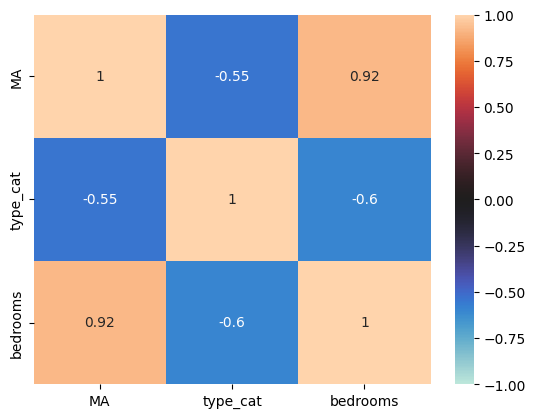

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_mat = init_df[["MA","type_cat","bedrooms"]].corr()
sns.heatmap(data=corr_mat, annot=True, vmin=-1, vmax=1, center=0)

<Axes: xlabel='type', ylabel='MA'>

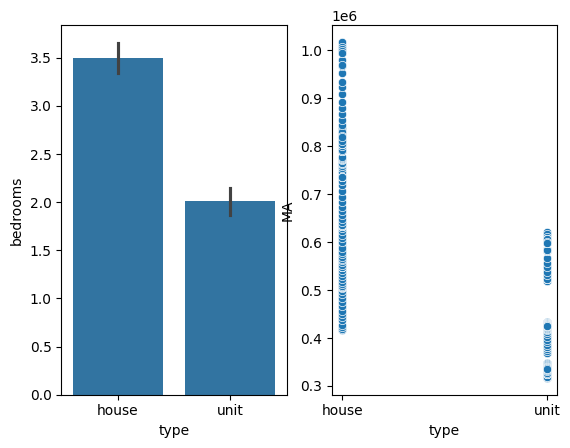

In [6]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=init_df, x="type", y="bedrooms", ax=ax[0])
sns.scatterplot(data=init_df, x="type", y="MA", ax=ax[1])

Baseado nos valores observados e na temática dos dados, podemos inferir que o conjunto apresenta dois tipos de imóveis residênciais, __casas__ e __unidades__, que podem ser descritos como alojamentos unitários, a partir da correlação entre quantidades de cômodos (bedrooms) entre os dois tipos.

Dado esse argumento observa-se que os alojamentos apresentam preços menores.

Observamos que o atributo temporal 'saledate' está formatado como __string__ e precisa passar por transformações para ser devidamente usado.  
No entanto, podemos também discretizar o o período, mapeando os valores de data com valores inteiros, o que permite anonimizar valores (caso necessário) e trabalhar com valores períodicos discretos.

<Axes: xlabel='discrete_period', ylabel='MA'>

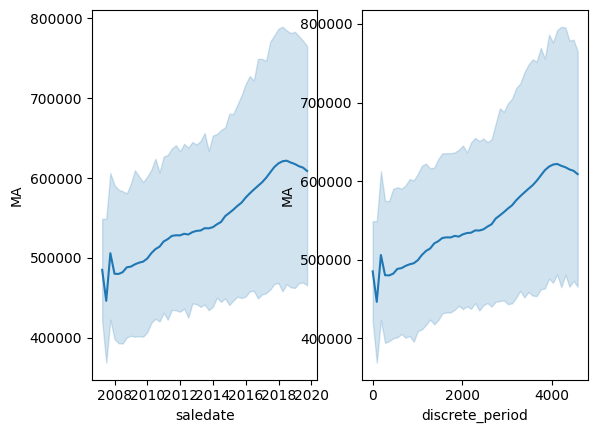

In [7]:
"""
@note
Para realizar a discretização primeiramente devemos arrumar o formato da data.
Você que é cientista de dados e guarda data como string, favor, migrar para DBA.
Ass: presidente do mundo.

@about
Convert string to pandas.datetime and map each unique date value as an integer.
The count starts from the earliest date possible (dataframe['datevalue'].min()).
"""
init_df['saledate'] = pandas.to_datetime(init_df['saledate'], dayfirst=True)
init_df.sort_values(by=['saledate'], inplace=True)
init_df['discrete_period'] = init_df['saledate'].map(lambda date : (pandas.Timestamp(date) - init_df['saledate'].min()).days )

fig, ax =plt.subplots(1,2)
sns.lineplot(data=init_df, x="saledate", y="MA", ax=ax[0])
sns.lineplot(data=init_df, x="discrete_period", y="MA", ax=ax[1])

A celula abaixo existe única e exclusivamente para verificar à evolução dos preços dos imóveis ao longo do tempo, e comprovar que a discretização de valores temporais não afeta os resultados.  

In [8]:
sales_index_df = init_df.copy()
sales_index_df.drop(columns=["bedrooms","type", "type_cat"], inplace=True)
sales_index_df['MA_diff'] = sales_index_df['MA'].diff()
sales_index_df.dropna(inplace=True)

<Axes: >

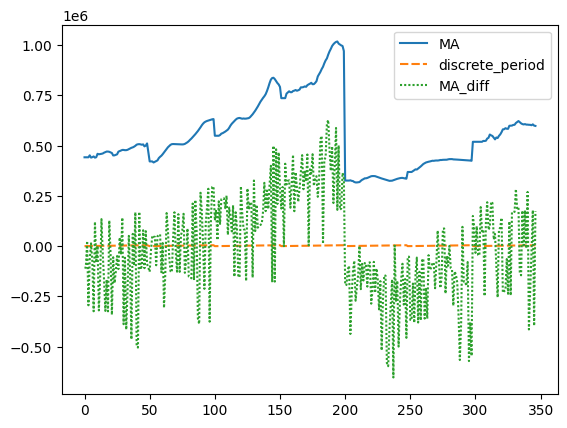

In [9]:
sns.lineplot(sales_index_df)

## Série Temporal e LSTM

In [10]:
def create_sequences(data, step_back=1):
    X, y = [], []
    for i in range(len(data) - step_back):
        X.append(data[i:i + step_back, 0])
        y.append(data[i + step_back, 0])
    return np.array(X), np.array(y)

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = sales_index_df[['MA_diff']].values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

In [12]:
step_back = 1
X, y = create_sequences(scaled_data, step_back)
X = X.reshape((X.shape[0], step_back, 1))

train_size = int(len(X) * 0.5)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def build_and_train_lstm(X_train, y_train, X_test, y_test, lstm_units):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(step_back, 1)))
    model.add(LSTM(units=lstm_units))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    return model, history

In [14]:
model_5_lstm, history_5_lstm = build_and_train_lstm(X_train, y_train, X_test, y_test, 5)
model_10_lstm, history_10_lstm = build_and_train_lstm(X_train, y_train, X_test, y_test, 10)

Epoch 1/20


C:\Users\Thiago Rafael\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0945 - val_loss: 0.1929
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0922 - val_loss: 0.1924
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0993 - val_loss: 0.1919
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1029 - val_loss: 0.1914
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1005 - val_loss: 0.1909
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1031 - val_loss: 0.1905
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0988 - val_loss: 0.1899
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1027 - val_loss: 0.1894
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1047 - val_loss: 0.1889
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1051 - val_loss: 0.1883
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1055 - val_loss: 0.1878
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1000 - val_loss: 0.1872
Epoch 13/20
6/6 ━━━━━━━

In [15]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    return train_predictions, test_predictions, y_train_actual, y_test_actual

In [16]:
train_predictions_5_lstm, test_predictions_5_lstm, y_train_actual, y_test_actual = evaluate_model(model_5_lstm, X_train, y_train, X_test, y_test)
train_predictions_10_lstm, test_predictions_10_lstm, _, _ = evaluate_model(model_10_lstm, X_train, y_train, X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


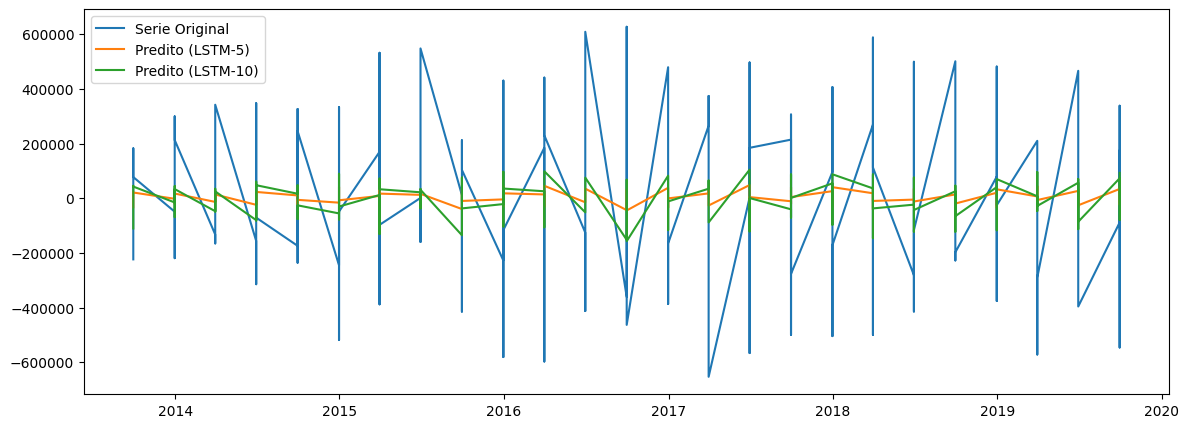

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(sales_index_df['saledate'][train_size + step_back:], y_test_actual, label='Serie Original')
plt.plot(sales_index_df['saledate'][train_size + step_back:], test_predictions_5_lstm, label='Predito (LSTM-5)')
plt.plot(sales_index_df['saledate'][train_size + step_back:], test_predictions_10_lstm, label='Predito (LSTM-10)')
plt.legend()
plt.show()

Devido os saltos temporais do conjunto, nota-se um baixo desempenho na predição das séries.
Isso se deve ao fato de que os valores pulam em períodos de meses e anos, o que causa problemas no processamento.

Técnicas de imputação podem gerar resultados significativos com o risco de causar enviesamento nos dados.

Tudo o que sabemos é que casas são caras e um jovem jamais conseguiria adquirir uma sozinho.